## Import dependencies

In [42]:
# autosave every 60 seconds
%autosave 60

# display full output in Notebook, instead of only the last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")

# latex font for plots
# plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
# #Options
# params = {'text.usetex' : True,
#           'font.size' : 12,
#           'font.family' : 'lmodern',
#           'text.latex.unicode': True,
#           }
# plt.rcParams.update(params) 


# standard libraries
import numpy as np
import pandas as pd
import os
import json
from datetime import datetime, timezone
import time

# make this notebook's output stable across runs
np.random.seed(42)
    
# ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# ARIMA model
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# indicate how many differencing rounds are necessary
from pmdarima.arima.utils import ndiffs


# ml libraries
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.base import clone

import xgboost as xgb
from xgboost import plot_importance, plot_tree

# store model
import pickle

Autosaving every 60 seconds


## Import Data

In [43]:
data_path = "../00_data"

df_rapperswil = pd.read_csv(os.path.join(data_path, "features_rapperswil.csv"), sep=",")
df_burgdorf = pd.read_csv(os.path.join(data_path, "features_burgdorf.csv"), sep=",")

print('Dataset shape of Rapperswil data: {}'.format(df_rapperswil.shape))
print('Dataset shape of Burgdorf data: {}'.format(df_burgdorf.shape))

df_rapperswil
df_burgdorf

Dataset shape of Rapperswil data: (12317, 18)
Dataset shape of Burgdorf data: (7164, 18)


,date,t-7,t-3,t-2,t-1,occupancy_rate,date_only,hour,day_of_week,day_name,quarter,month,day_of_year,day_of_month,week_of_year,temperature,weather,holiday
0,2020-06-01 07:00:00,12.582781,6.643357,8.940397,10.927152,12.913907,2020-06-01,7,0,Monday,2,6,153,1,23,275.82,Clouds,1
1,2020-06-01 08:00:00,6.993007,8.940397,10.927152,12.913907,14.900662,2020-06-01,8,0,Monday,2,6,153,1,23,275.22,Clouds,1
2,2020-06-01 09:00:00,7.284768,10.927152,12.913907,14.900662,19.081272,2020-06-01,9,0,Monday,2,6,153,1,23,274.02,Clouds,1
3,2020-06-01 10:00:00,7.342657,12.913907,14.900662,19.081272,34.105960,2020-06-01,10,0,Monday,2,6,153,1,23,276.22,Clouds,1
4,2020-06-01 11:00:00,6.643357,14.900662,19.081272,34.105960,53.973510,2020-06-01,11,0,Monday,2,6,153,1,23,277.84,Clouds,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12312,2021-10-27 08:00:00,3.478261,3.478261,5.241935,13.043478,46.568627,2021-10-27,8,2,Wednesday,4,10,300,27,43,297.88,Rain,0
12313,2021-10-27 09:00:00,3.773585,5.241935,13.043478,46.568627,78.629032,2021-10-27,9,2,Wednesday,4,10,300,27,43,294.47,Rain,0
12314,2021-10-27 10:00:00,3.225806,13.043478,46.568627,78.629032,85.887097,2021-10-27,10,2,Wednesday,4,10,300,27,43,291.80,Thunderstorm,0
12315,2021-10-27 11:00:00,3.773585,46.568627,78.629032,85.887097,89.919355,2021-10-27,11,2,Wednesday,4,10,300,27,43,290.92,Rain,0


,date,t-7,t-3,t-2,t-1,occupancy_rate,date_only,hour,day_of_week,day_name,quarter,month,day_of_year,day_of_month,week_of_year,temperature,weather,holiday
0,2021-01-01 07:00:00,0.96,4.69,4.06,0.67,2.21,2021-01-01,7,4,Friday,1,1,1,1,53,275.86,Rain,1
1,2021-01-01 08:00:00,4.73,4.06,0.67,2.21,4.61,2021-01-01,8,4,Friday,1,1,1,1,53,275.38,Clouds,1
2,2021-01-01 09:00:00,4.69,0.67,2.21,4.61,4.88,2021-01-01,9,4,Friday,1,1,1,1,53,273.24,Clouds,1
3,2021-01-01 10:00:00,4.69,2.21,4.61,4.88,4.64,2021-01-01,10,4,Friday,1,1,1,1,53,276.45,Clouds,1
4,2021-01-01 11:00:00,4.69,4.61,4.88,4.64,3.75,2021-01-01,11,4,Friday,1,1,1,1,53,278.26,Clouds,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7159,2021-10-26 14:00:00,68.67,60.86,48.33,36.77,22.25,2021-10-26,14,1,Tuesday,4,10,299,26,43,283.49,Clouds,0
7160,2021-10-26 15:00:00,74.18,48.33,36.77,22.25,15.68,2021-10-26,15,1,Tuesday,4,10,299,26,43,282.34,Clouds,0
7161,2021-10-26 16:00:00,77.38,36.77,22.25,15.68,11.74,2021-10-26,16,1,Tuesday,4,10,299,26,43,285.38,Clear,0
7162,2021-10-26 17:00:00,72.18,22.25,15.68,11.74,5.53,2021-10-26,17,1,Tuesday,4,10,299,26,43,287.13,Clear,0


## Explorative Data Analysis

In [44]:
# format date columns

df_burgdorf['date_only'] = pd.to_datetime(df_burgdorf.date_only)
df_rapperswil['date_only'] = pd.to_datetime(df_rapperswil.date_only)
df_rapperswil['date'] = pd.to_datetime(df_rapperswil.date)
df_burgdorf['date'] = pd.to_datetime(df_burgdorf.date)

a) Average parking occupancy by date 

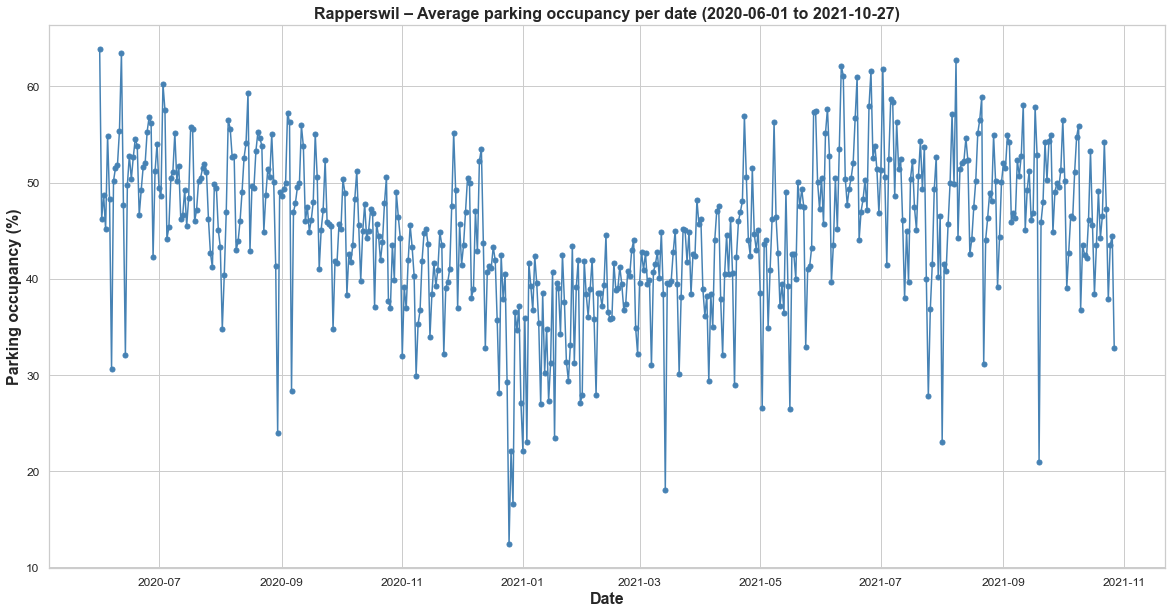

In [45]:
y = df_rapperswil.groupby('date_only')['occupancy_rate'].mean()
x = df_rapperswil.groupby('date_only')['occupancy_rate'].mean().index # date column


fig = plt.figure(figsize=(20,10));
ax = fig.add_subplot(111);

plt.plot(x, y, marker=".", markersize=10, color="steelblue");
plt.title('Rapperswil – Average parking occupancy per date (' + str(df_rapperswil.date_only.min().date()) + ' to '
                                         + str(df_rapperswil.date_only.max().date()) + ')',
                                         fontsize = 16, weight = 'bold');

plt.xlabel('Date', fontsize = 16, weight = 'bold');
plt.ylabel('Parking occupancy (%)', fontsize = 16, weight = 'bold');
#plt.show();

# save fig
file = 'rapperswil_all_dates'
file_type = '.png' 
datestamp = datetime.now()
plt.savefig('/Users/christopherkindl/working/start-hack-2021/05_visualisations_of_eda/'
            + file
            + str(datestamp)[:-7]
            + file_type, 
           facecolor=fig.get_facecolor(), edgecolor='none');

b) parking occupancy aggregated

@Yvan siehe best practice 

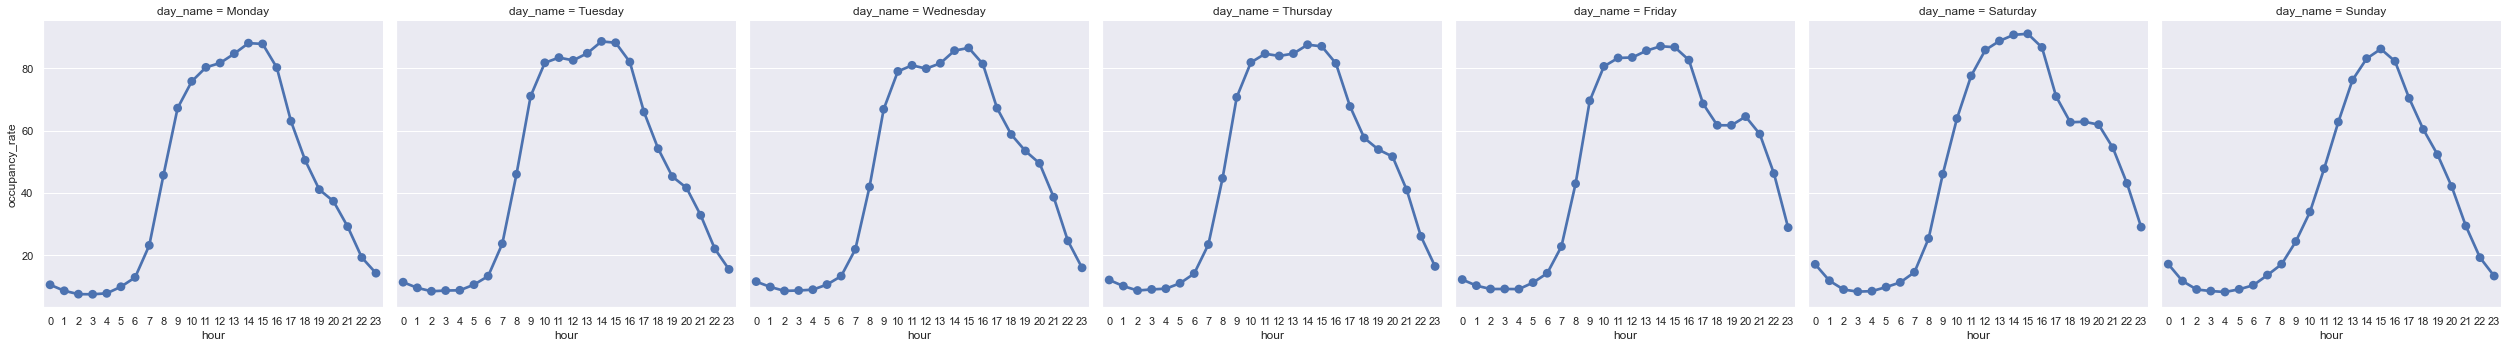

In [46]:
sns.set(rc={'figure.figsize':(20,10)})
sns.catplot(kind='point', data=df_rapperswil, col='day_name', x='hour', y='occupancy_rate', ci=None,
            order=sorted(df_rapperswil.hour.unique()), col_order=df_rapperswil.day_name.unique());
# plt.xlabel('Date', fontsize = 16, weight = 'bold');
# plt.ylabel('Parking occupancy (%)', fontsize = 16, weight = 'bold');

# save fig
file = 'rapperswil_aggregated_'
file_type = '.png' 
datestamp = datetime.now()
plt.savefig('../05_visualisations_of_eda/'
            + file
            + str(datestamp)[:-7]
            + file_type, 
           facecolor=fig.get_facecolor(), edgecolor='none');

## Train/Test Split

In [47]:
split_date = '2021-07-01'
split_date = datetime.strptime(split_date, '%Y-%m-%d').date()

In [48]:
# convert column
df_rapperswil['date_only'] = df_rapperswil['date_only'].dt.date 

# split df into train and test set
split_date = '2021-07-01'
split_date = datetime.strptime(split_date, '%Y-%m-%d').date()

df_train = df_rapperswil.loc[df_rapperswil['date_only'] <= split_date].copy()
df_test = df_rapperswil.loc[df_rapperswil['date_only'] > split_date].copy()

## ARIMA Model

Model parameters:

- **p:** The number of lag observations included in the model, also called the lag order.
- **d:** The number of times that the raw observations are differenced, also called the degree of differencing.
- **q:** The size of the moving average window, also called the order of moving average.

Preliminary steps:

**1) Stationarity:**
ARIMA models assumes non-stationarity. If stationarity exists, we need to difference the time series

**2) Analyse Auto-Correlation:** We use auto correlation function (ACF) and partial auto correlation function (PACF) to determine the optimal number of MA and AR terms


In [20]:
# assign datetime as column for statistical test
df_train['date'] = df_train.index 

# only keep date and one variable series
# df_train = df_train[['date', 'occupancy_rate']]

# apply stationarity test and add attributes
result = adfuller(df_rapperswil['occupancy_rate'])
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -10.024218168224444,
 'pvalue': 1.648319300312084e-17,
 'usedlag': 40,
 'nobs': 12276,
 'criticalvalues': {'1%': -3.430882801230906,
  '5%': -2.861775471258253,
  '10%': -2.566895336332719},
 'icbest': 79342.99773145982}

We failed to reject the Null Hypothesis meaning that the series is not stationary. We apply first differencing and test again.

In [21]:
df_rapperswil['1_difference'] = df_rapperswil['occupancy_rate'] - df_rapperswil['occupancy_rate'].shift(1)
result = adfuller(df_rapperswil['1_difference'].dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -27.164002943550287,
 'pvalue': 0.0,
 'usedlag': 40,
 'nobs': 12275,
 'criticalvalues': {'1%': -3.430882844645384,
  '5%': -2.86177549044354,
  '10%': -2.5668953465449373},
 'icbest': 79433.27023083618}

**Result stationarity:** \
We can reject the null hypothesis meaning that we can achieve stationarity by using the first derivation. Therefore, we use 1 for parameter $d$.

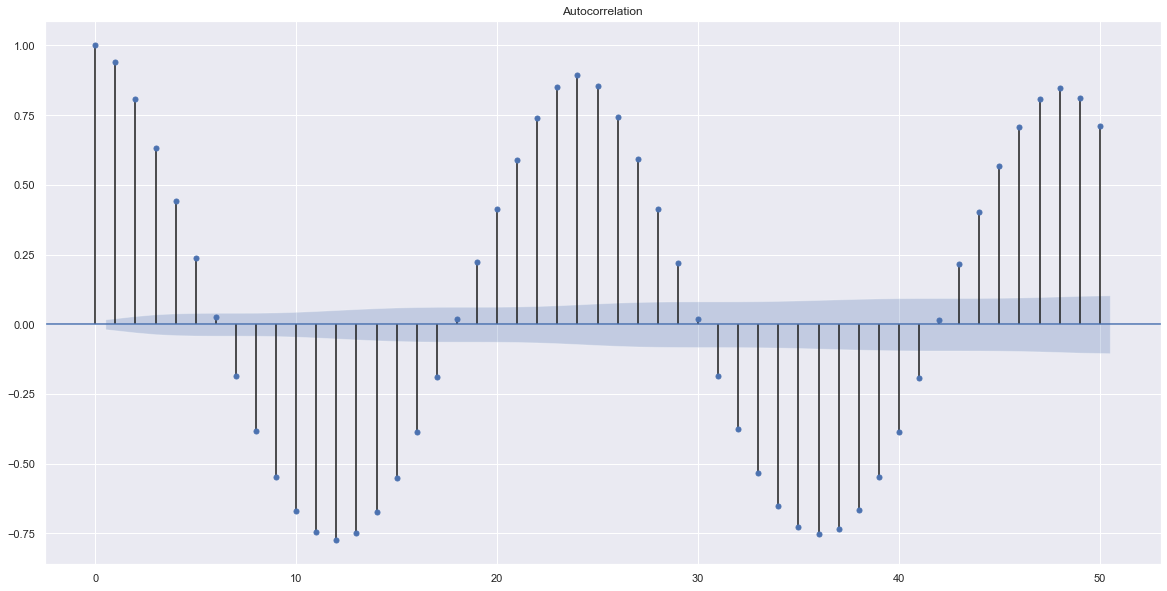

In [22]:
acf = plot_acf(df_rapperswil.occupancy_rate, lags = 50)

**Result Auto-Correlation:**

In [ ]:
Interpretation to be done

## Fit ARIMA Model

In [23]:
# apply grid search to identify best parameters for ARIMA model (p, d, q)
stepwise_model = auto_arima(df_train['occupancy_rate'], seasonal=True, trace=True)

# fit model using best parameters identified
stepwise_model.fit(df_train['occupancy_rate'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=66621.089, Time=4.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=72160.050, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=66827.367, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=67997.119, Time=1.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=72158.050, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=66619.801, Time=2.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=66825.828, Time=1.63 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=66667.456, Time=1.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=12.83 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=66644.630, Time=2.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=66647.081, Time=2.80 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=66619.717, Time=10.87 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=66413.025, Time=16.78 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=14.52 sec
 ARIMA(4,1,3)(0,0,0)[0] int

ARIMA(order=(4, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [24]:
# fit model using best parameters identified
stepwise_model.fit(df_train['occupancy_rate'])

ARIMA(order=(4, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

## Forecast on Test Set

1) Calculate standard metrics

In [49]:
df_train

,date,t-7,t-3,t-2,t-1,occupancy_rate,date_only,hour,day_of_week,day_name,quarter,month,day_of_year,day_of_month,week_of_year,temperature,weather,holiday
0,2020-06-01 07:00:00,12.582781,6.643357,8.940397,10.927152,12.913907,2020-06-01,7,0,Monday,2,6,153,1,23,275.82,Clouds,1
1,2020-06-01 08:00:00,6.993007,8.940397,10.927152,12.913907,14.900662,2020-06-01,8,0,Monday,2,6,153,1,23,275.22,Clouds,1
2,2020-06-01 09:00:00,7.284768,10.927152,12.913907,14.900662,19.081272,2020-06-01,9,0,Monday,2,6,153,1,23,274.02,Clouds,1
3,2020-06-01 10:00:00,7.342657,12.913907,14.900662,19.081272,34.105960,2020-06-01,10,0,Monday,2,6,153,1,23,276.22,Clouds,1
4,2020-06-01 11:00:00,6.643357,14.900662,19.081272,34.105960,53.973510,2020-06-01,11,0,Monday,2,6,153,1,23,277.84,Clouds,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492,2021-07-01 19:00:00,87.062937,93.356643,82.517483,70.078740,70.629371,2021-07-01,19,3,Thursday,3,7,182,1,26,267.95,Snow,0
9493,2021-07-01 20:00:00,83.566434,82.517483,70.078740,70.629371,71.259843,2021-07-01,20,3,Thursday,3,7,182,1,26,268.08,Clouds,0
9494,2021-07-01 21:00:00,91.338583,70.078740,70.629371,71.259843,56.756757,2021-07-01,21,3,Thursday,3,7,182,1,26,267.87,Clouds,0
9495,2021-07-01 22:00:00,93.006993,70.629371,71.259843,56.756757,29.569892,2021-07-01,22,3,Thursday,3,7,182,1,26,267.79,Clouds,0


In [57]:
df_train.set_index('date', inplace = True)
df_train.index = df_train.index.to_period('h')


# fit model
model = ARIMA(df_train['occupancy_rate'], order=(4,1,2))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

/Users/christopherkindl/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christopherkindl/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/christopherkindl/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


                               SARIMAX Results                                
Dep. Variable:         occupancy_rate   No. Observations:                 9497
Model:                 ARIMA(4, 1, 2)   Log Likelihood              -32968.358
Date:                Wed, 17 Nov 2021   AIC                          65950.715
Time:                        17:33:30   BIC                          66000.825
Sample:                    06-01-2020   HQIC                         65967.721
                         - 07-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7267      0.010    174.633      0.000       1.707       1.746
ar.L2         -1.7533      0.019    -91.857      0.000      -1.791      -1.716
ar.L3          0.7596      0.019     40.612      0.0

In [58]:
start = len(df_train) 
end = len(df_train) + len(df_test) - 1

df_test['prediction_ARIMA'] = model_fit.predict(start=start,end=end,typ="levels")

In [ ]:
# compute average MAE and MSE
# date_filter = 600
# model = 'prediction_ARIMA'
# df_test.dropna(inplace= True)

# print(round(mean_absolute_error(y_true=df_test['occupancy_rate'], y_pred=df_test[model]), 3))
# print(round(mean_squared_error(y_true=df_test['occupancy_rate'], y_pred=df_test[model]), 3))

2) Plot actuals and predicted values

In [ ]:
# model performance to plot
# model = 'prediction_ARIMA'
# 
# fig = plt.figure(figsize=(20,8));
# ax = fig.add_subplot(111);
# _ = df_test[['occupancy_rate', model]].plot(ax=ax, style=['-','-'], linewidth=2, color=['steelblue', 'darkorange'])
# 
# ax.set_xbound(lower='2021-07-01', upper= str(df_test.index.max().date()))
# # plot = plt.suptitle('Autumn 2021 Forecast vs Actuals')
# plt.title('ARIMA: Forecast vs Actuals',
#            fontsize = 16, weight = 'bold');
# plt.xlabel('Date', fontsize = 14, weight = 'bold');
# plt.ylabel('Parking occupancy', fontsize = 14, weight = 'bold');
# 
# 
# # save fig
# file = 'rapperswil_arima.png'
# plt.savefig('/Users/christopherkindl/working/start-hack-2021/05_visualisations_of_eda/' + file, 
           facecolor=fig.get_facecolor(), edgecolor='none');

## Save Model

Example code

In [ ]:
# export model parameters
model_name = 'arima.sav'
pickle.dump(model, open(model_name, 'wb'))

In [ ]:
# load model
loaded_model = pickle.load(open(model_name, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

## Feature Scaling for Advanced Models

In [216]:
# set date column as index
# df_rapperswil = df_rapperswil.set_index('date')

In [63]:
# convert column
# df_rapperswil['date_only'] = df_rapperswil['date_only'].dt.date 

# split df into train and test set
split_date = '2021-07-01'
split_date = datetime.strptime(split_date, '%Y-%m-%d').date()

df_train = df_rapperswil.loc[df_rapperswil['date_only'] <= split_date].copy()
df_test = df_rapperswil.loc[df_rapperswil['date_only'] > split_date].copy()

In [64]:
# define function to split df accordingly 
def split(df, label=None):    
    X = df[[ #'date_only',
             'hour',
             'day_of_week',
             'quarter',
             'month',
             'day_of_year',
             'day_of_month',
             'week_of_year',
             'temperature',
             'weather',
             'holiday',
             't-7',
             't-3',
             't-2',
             't-1']]
    if label:
        y = df[label]
        return X, y
    return X

In [70]:
# apply functions
X_train, y_train = split(df_train, label='occupancy_rate')
X_test, y_test = split(df_test, label='occupancy_rate')

In [71]:
# convert categorical column
X_train['weather'] = pd.Categorical(X_train['weather'])
X_test['weather'] = pd.Categorical(X_test['weather'])

<ipython-input-71-3f85e03db52f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['weather'] = pd.Categorical(X_train['weather'])
<ipython-input-71-3f85e03db52f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['weather'] = pd.Categorical(X_test['weather'])


In [72]:
#split numerical and categorical columns
data_num = X_train.select_dtypes(include=[np.number])
data_cat = X_train.select_dtypes(include=[np.object])

#create data pipeline
num_pipeline = Pipeline([('std_scaler', StandardScaler())])

num_attribs = list(data_num)
cat_attribs = list(data_cat)

full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_attribs),
        ('cat', OneHotEncoder(), cat_attribs)])

X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

## Create Advanced Models

## 1. XGBoost

In [73]:
# initialize XGB model
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
       early_stopping_rounds=50,
       verbose=False) # set false to not see training progress

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Forecast on test set

1) Calculate standard metrics

In [74]:
model = 'prediction_xgboost'

df_test[model] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

In [75]:
# compute average MAE and MSE
# date_filter = 600
model = 'prediction_xgboost'

print(round(mean_absolute_error(y_true=df_test['occupancy_rate'], y_pred=df_test[model]), 3))
print(round(mean_squared_error(y_true=df_test['occupancy_rate'], y_pred=df_test[model]), 3))

3.925
35.412


2) Plot actuals and predicted values

In [80]:
df_all.set_index('date', inplace = True)

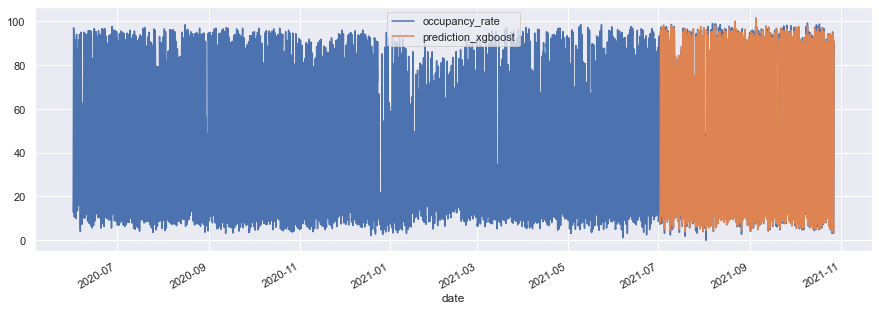

In [81]:
model = 'prediction_xgboost'
df_all[['occupancy_rate', model]].plot(figsize=(15, 5))

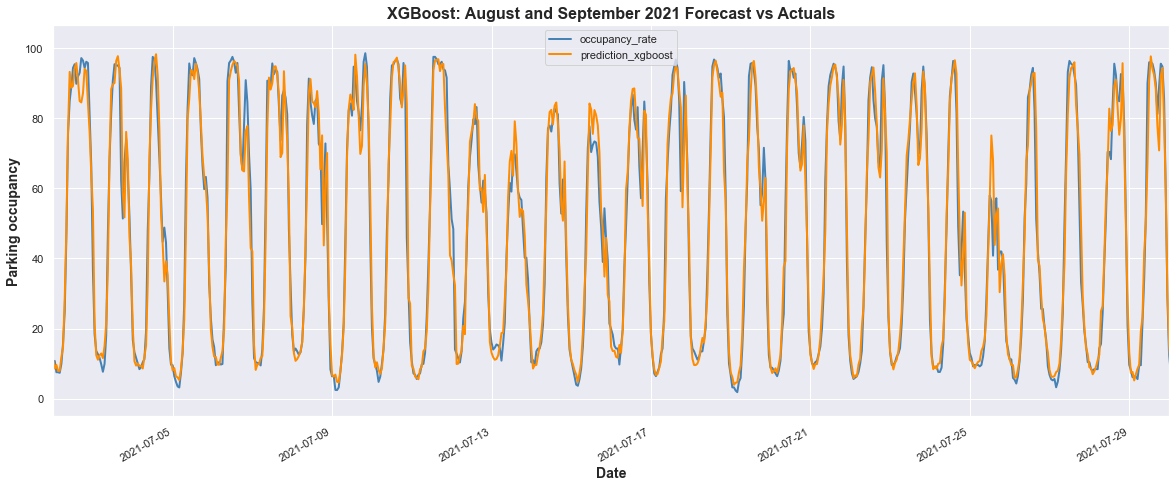

In [82]:
# Plot the forecast with the actuals
model = 'prediction_xgboost'

fig = plt.figure(figsize=(20,8));
ax = fig.add_subplot(111);
_ = df_all[['occupancy_rate', model]].plot(ax=ax, style=['-','-'], linewidth=2, color=['steelblue', 'darkorange'])

ax.set_xbound(lower='2021-07-02', upper='2021-07-30')
# plot = plt.suptitle('Autumn 2021 Forecast vs Actuals')
plt.title('XGBoost: August and September 2021 Forecast vs Actuals',
           fontsize = 16, weight = 'bold');
plt.xlabel('Date', fontsize = 14, weight = 'bold');
plt.ylabel('Parking occupancy', fontsize = 14, weight = 'bold');


# save fig

file = 'burgdorf_xgboost.png'
plt.savefig('/Users/christopherkindl/working/start-hack-2021/05_visualisations_of_eda/' + file, 
           facecolor=fig.get_facecolor(), edgecolor='none');

Look at Worst and Best Predicted Days

In [83]:
# aggregate data
df_all['error'] = df_all['occupancy_rate'] - df_all['prediction_xgboost']
df_all['abs_error'] = df_all['error'].apply(np.abs)
error_by_day = df_all.groupby(['month','day_of_month']) \
    .mean()[['occupancy_rate','prediction_xgboost','error','abs_error']]

In [84]:
error_by_day.sort_values('error', ascending=True).head(10)

occupancy_rate  prediction_xgboost     error  abs_error
month day_of_month                                                         
8     2                  38.146010           45.929127 -4.422278   7.463778
7     15                 42.606007           41.966358 -2.254331   6.276457
      3                  55.396727           52.558311 -2.009839   5.462806
      24                 45.956065           41.943542 -1.985207   5.239386
      25                 39.456889           29.480907 -1.713400   5.483137
      30                 44.833804           41.882977 -1.699642   4.495237
      10                 50.792849           53.085087 -1.698551   4.687746
      31                 45.794861           48.173985 -1.619372   5.946143
      26                 41.495952           38.419708 -1.612292   4.224992
9     19                 35.720130           22.510485 -1.605126   3.178606

## 2. Random Forest

In [85]:
# initialise model
rf = RandomForestRegressor(n_estimators=100, random_state=42) # will be optimised by grid search
rf.fit(X_train, y_train) 

RandomForestRegressor(random_state=42)

## Forecast on Test Set

1) Calculate standard metrics

In [86]:
model = 'prediction_rf'
df_test[model] = rf.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

In [87]:
# compute average MAE and MSE
# date_filter = 150
model = 'prediction_rf'

print(round(mean_absolute_error(y_true=df_test['occupancy_rate'], y_pred=df_test[model]), 3))
print(round(mean_squared_error(y_true=df_test['occupancy_rate'], y_pred=df_test[model]), 3))

3.993
37.669


2) Plot actuals and predicted values

In [89]:
df_all.set_index('date', inplace = True)

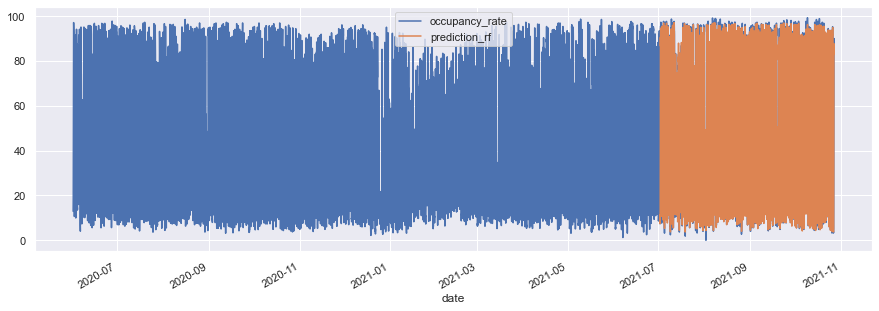

In [90]:
model = 'prediction_rf'
df_all[['occupancy_rate', model]].plot(figsize=(15, 5))

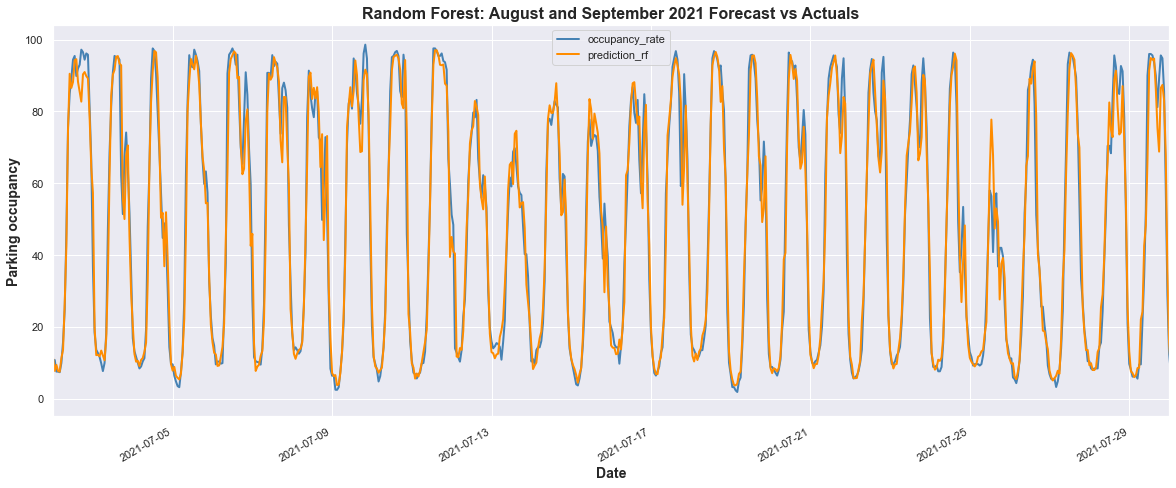

In [91]:
# Plot the forecast with the actuals
model = 'prediction_rf'

fig = plt.figure(figsize=(20,8));
ax = fig.add_subplot(111);
_ = df_all[['occupancy_rate', model]].plot(ax=ax, style=['-','-'], linewidth=2, color=['steelblue', 'darkorange'])

ax.set_xbound(lower='2021-07-02', upper='2021-07-30')
# plot = plt.suptitle('Autumn 2021 Forecast vs Actuals')
plt.title('Random Forest: August and September 2021 Forecast vs Actuals',
           fontsize = 16, weight = 'bold');
plt.xlabel('Date', fontsize = 14, weight = 'bold');
plt.ylabel('Parking occupancy', fontsize = 14, weight = 'bold');


# save fig

file = 'burgdorf_rf.png'
plt.savefig('/Users/christopherkindl/working/start-hack-2021/05_visualisations_of_eda/' + file, 
           facecolor=fig.get_facecolor(), edgecolor='none');